In [38]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, exp, log
from scipy.optimize import newton, bisect
import sys

np.set_printoptions(linewidth=132, suppress=True)

In [39]:
from pstudio import AE
ae = AE('C', xcname='LDA', relativity='SR', out='-')
ae.run()


scalar relativistic atomic calculation for C (Carbon, Z=6)
configuration: 1s2 2s2 2p2, 6 electrons
exchange-correlation: lda_x+lda_c_pz
2001 radial gridpoints in [1e-05,100]

Converged in 63 iterations

Energy contributions:
------------------------------------------------------------------------
Kinetic:      +37.269733 Ha     +1014.161102 eV 
Ionic:        -87.619337 Ha     -2384.243613 eV 
Hartree:      +17.627276 Ha      +479.662609 eV 
XC:            -4.732032 Ha      -128.765157 eV 
------------------------------------------------------------------------
Total:        -37.454308 Ha     -1019.183627 eV 

state      eigenvalue      eigenvalue        rmax
------------------------------------------------------------------------
1s2         -9.961701 Ha  -271.071678 eV    0.175
2s2         -0.501784 Ha   -13.654238 eV    1.218
2p2         -0.199279 Ha    -5.422666 eV    1.189



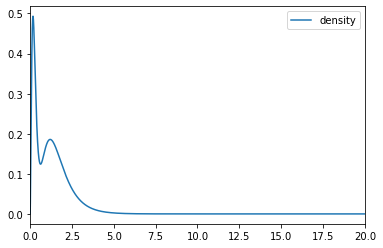

In [40]:
r = ae.rgd.r
# plot density
plt.figure()
plt.plot(r, ae.n*r*r, label='density')
plt.xlim(0,20)
plt.legend()
plt.show(block=False)

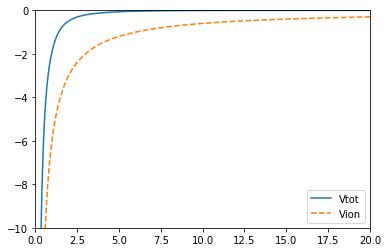

In [41]:
# plot the potential
plt.figure()
plt.plot(r, ae.vtot, label='Vtot')
plt.plot(r, ae.vion, label='Vion', linestyle='dashed')
plt.xlim(0,20)
plt.ylim(-10,0)
plt.legend()
plt.show(block=False)

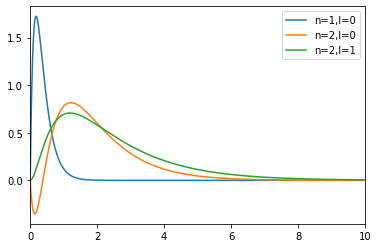

In [42]:
# plot orbitals
plt.figure()
for orb in ae.orbitals:
    plt.plot(r, orb.ur, label='n={0},l={1}'.format(orb.n,orb.l))
plt.xlim(0,10)
plt.legend()
plt.show()

rc (effective)= 1.4655478409559122 g= 1476
0.7813995847445941 0.7813995847308792


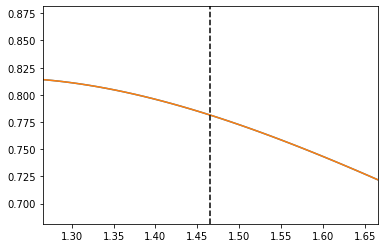

In [43]:
orb = ae.orbitals[1]
rc = orb.find_rmax(ae.rgd)*1.2
g = ae.rgd.floor(rc)
rc = r[g]
print('rc (effective)=', rc, 'g=', g)
l = orb.l
ae2s = orb.ur.copy()

# to calculate derivatives of AE wfc
p = np.polyfit(r[g-10:g+10], ae2s[g-10:g+10], deg=6)
print(ae2s[g], np.polyval(p,rc))

plt.plot(r, ae2s)
plt.plot(r, np.polyval(p, r))
plt.axvline(rc, color='black', linestyle='dashed')
plt.xlim(rc-0.2,rc+0.2)
plt.ylim(ae2s[g]-0.1, ae2s[g]+0.1)
plt.show()

In [44]:
# first MT condition: norm conservation
ae_norm = np.sum(ae2s[:g]*ae2s[:g] * ae.rgd.dr[:g])
print('norm within rc:', ae_norm)

#derivatives of AE wfc
ae_deriv = [np.polyval(np.polyder(p,i),rc) for i in range(5)]
for i,d in enumerate(ae_deriv):
    print('{0}-th derivative: {1}'.format(i, d))

norm within rc: 0.49879075749060325
0-th derivative: 0.7813995847308792
1-th derivative: -0.24473182515891612
2-th derivative: -0.6545393945177249
3-th derivative: 2.1787123238709603
4-th derivative: -4.485614510934169


In [45]:
def TM_function(r, l, c):
    """Evaluate the TM pseudowfc"""
    c0, c2, c4, c6, c8, c10, c12 = c
    poly = np.array([c12,0,c10,0,c8,0,c6,0,c4,0,c2,0,c0])
    return r**(l+1) * np.exp(np.polyval(poly,r))

def TM_linear_problem(c2, rc, ae_deriv, l):
    """Construct the TM linear problem as a function of c2"""
    # first the left hand side
    lhs = np.zeros((6,7))
    p = np.array([0,2,4,6,8,10,12])   # powers
    c = np.array([1,1,1,1,1,1,1])     # coefficients
    for i in range(5):
        lhs[i,:] = c * rc**p
        c = c*p
        p = np.array([max(0,p[j]-1) for j in range(7)])
    lhs[5,2] = 2*l + 5                # coefficient of c4
    
    # then the left hand side
    rhs = np.zeros(6)
    rhs[0] = log(ae_deriv[0]/rc**(l+1))
    rhs[1] = -(l+1)/rc + ae_deriv[1]/ae_deriv[0]
    rhs[2] = (l+1)/rc**2 + ae_deriv[2]/ae_deriv[0] - ae_deriv[1]**2/ae_deriv[0]**2
    rhs[3] = -2*(l+1)/rc**3 + ae_deriv[3]/ae_deriv[0] - 3*ae_deriv[1]*ae_deriv[2]/ae_deriv[0]**2 \
             + 2*ae_deriv[1]**3/ae_deriv[0]**3
    rhs[4] = +6*(l+1)/rc**4 + ae_deriv[4]/ae_deriv[0] - 4*ae_deriv[1]*ae_deriv[3]/ae_deriv[0]**2 \
             - 3*ae_deriv[2]**2/ae_deriv[0]**2 \
             +12*ae_deriv[1]**2*ae_deriv[2]/ae_deriv[0]**3 - 6*ae_deriv[1]**4/ae_deriv[0]**4

    # eliminate the column of c2 and move it to the rhs
    rhs -= c2*lhs[:,1]
    lhs = np.delete(lhs, (1), axis=1)
    rhs[5] = -c2*c2
    return lhs, rhs

#lhs, rhs = TM_linear_problem(1.0, rc, ae_deriv, l)
#print('LHS=')
#np.savetxt(sys.stdout, lhs, fmt='%10g')
#print('RHS=')
#np.savetxt(sys.stdout, rhs, fmt='%10g')
#print(np.linalg.solve(lhs,rhs))

In [46]:
def TM_solve_linear_problem(c2, ae_norm, ae_deriv, l):
    # solve linear part of the system
    lhs, rhs = TM_linear_problem(c2, rc, ae_deriv, l)
    c = np.linalg.solve(lhs, rhs)
    
    # put back c2 into the list
    c = list(c)
    c.insert(1, c2)
    return c

def TM_calc_residual(c2, ae_norm, ae_deriv, rgd, rc, l):
    # solve linear part of the system
    c = TM_solve_linear_problem(c2, rc, ae_deriv, l)

    # fix norm-conserving relation
    g = rgd.floor(rc)
    r = rgd.r[:g]
    ps_norm = np.sum(TM_function(r, l, c)**2 * rgd.dr[:g])
    diff = ps_norm - ae_norm
        
    return diff


def TM_find_coefficients(ae_norm, ae_deriv, rgd, rc, l):
    c2 = 0.0   # starting guess

    res = TM_calc_residual(c2, ae_norm, ae_deriv, ae.rgd, rc, l)
    print('initial c2=', c2, 'initial residual=', res)

    c2 = newton(lambda x: TM_calc_residual(x, ae_norm, ae_deriv, ae.rgd, rc, l), x0=c2)
    res = TM_calc_residual(c2, ae_norm, ae_deriv, ae.rgd, rc, l)
    print('final c2=', c2, 'final residual=', res)
    
    c = TM_solve_linear_problem(c2, ae_norm, ae_deriv, l)
    print('TM coefficients:', c)
    c0, c2, c4, c6, c8, c10, c12 = c
    print('norm error     :', np.sum(TM_function(r[:g], l, c)**2 * ae.rgd.dr[:g])- ae_norm)
    print('V"(0) condition:', (2*l+5)*c4 + c2*c2)

    return c

c = TM_find_coefficients(ae_norm, ae_deriv, ae.rgd, rc, l)

initial c2= 0.0 initial residual= 0.029278995825392673
final c2= 0.25801126669870406 final residual= 9.270362255620057e-15
TM coefficients: [-0.3186098794195898, 0.25801126669870406, -0.013313962748691531, -0.4076944868157691, 0.2816976451930441, -0.07719521362157461, 0.007844365740636579]
norm error     : 9.270362255620057e-15
V"(0) condition: 1.2129186544029835e-14


0.7813995847308792 0.7813995847308794


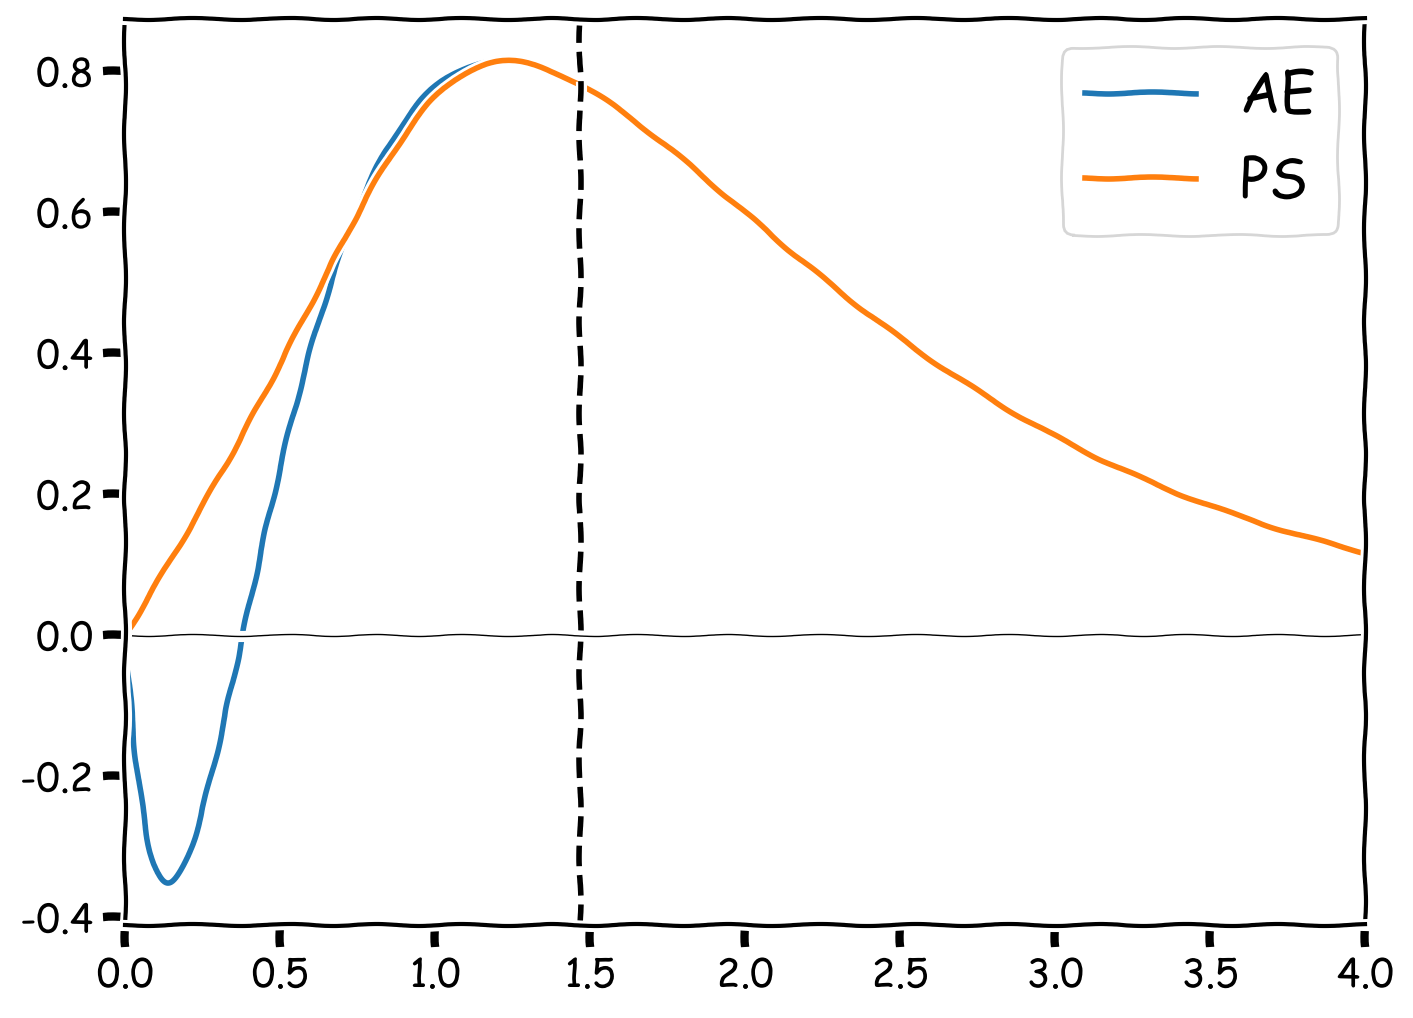

In [47]:
ps2s = ae2s.copy()
ps2s[:g] = TM_function(r[:g], l, c)
print(ae_deriv[0], TM_function(rc, l, c))

plt.xkcd(randomness=2)
fig = plt.figure(figsize=(8,6), dpi=200)
plt.plot(r, ae2s, label='AE')
plt.plot(r, ps2s, label='PS')
plt.axvline(rc, color='black', linestyle='dashed')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlim(0,4)
plt.legend(fontsize=20)
#plt.grid()
plt.savefig('pstudio.png', bbox_inches='tight')
plt.show()

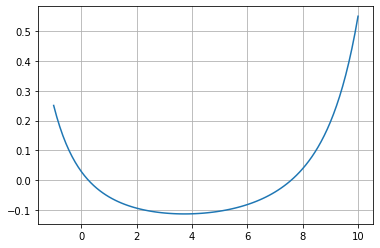

In [11]:
c2range = np.linspace(-1,10,100)
diff = np.zeros_like(c2range)
for i in range(len(c2range)):
    diff[i] = TM_calc_residual(c2range[i], ae_norm, ae_deriv, ae.rgd, rc, l)
plt.plot(c2range, diff)
plt.grid()
plt.show()

8 8.011061266653973
9 16.053538459843843
10 32.138492846223585
11 64.30840161898307
12 128.64821916450202
13 257.32785425553993


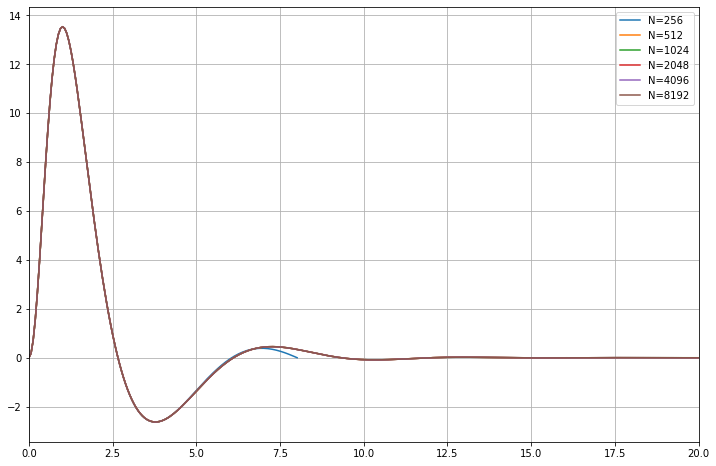

In [35]:
fig = plt.figure(figsize=(12,8))
for p in range(8,14):
    g, fg = ae.rgd.fft(ps2s, l, N=2**p)
    print(p, g[-1])
    plt.plot(g, fg*g*g, label='N={0}'.format(2**p))
plt.legend()
plt.xlim(0,20)
plt.grid()
plt.show()